# SixFifty GE2017 Model
## Constituency Level Forecast Model
For more information please see [SixFifty.org.uk](https://sixfifty.org.uk) or the [SixFifty Hackathon repo](https://github.com/six50/hackathon).

In [1]:
# Libaries that may or may not be useful
import feather
import matplotlib
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn import ensemble, linear_model, metrics, model_selection, neural_network, tree

# Config
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
DATA_DIR = Path('../data/')
%matplotlib inline

Running `data/retrieve_data.py` from the `hackathon` repo root will download the relevant datasets into the required location.

### Import model-ready General Election data for 2010 and 2015

In [2]:
parties = ['con', 'lab', 'ld', 'ukip', 'grn']

In [3]:
df = pd.read_feather(DATA_DIR / 'model' / 'ge_2010_2015_training_data.feather')
df.head(15)

,Press Association Reference,Constituency Name,Region,Electorate,Votes,party,votes_last,pc_last,win_last,polls_now,swing_now,swing_forecast_pc,swing_forecast_win,actual_win_now,actual_pc_now,con,grn,lab,ld,ukip,Region_East Midlands,Region_Eastern,Region_London,Region_North East,Region_North West,Region_Northern Ireland,Region_Scotland,Region_South East,Region_South West,Region_Wales,Region_West Midlands,Region_Yorkshire and the Humber,won_here_last
0,1.0,Aberavon,Wales,50838.0,30958,con,4411.0,0.142483,lab,0.338182,-0.062021,0.133646,lab,lab,0.118707,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1.0,Aberavon,Wales,50838.0,30958,lab,16073.0,0.519187,lab,0.337273,0.163400,0.604022,lab,lab,0.489040,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,1.0,Aberavon,Wales,50838.0,30958,ld,5034.0,0.162607,lab,0.090000,-0.609159,0.063554,lab,lab,0.044317,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1.0,Aberavon,Wales,50838.0,30958,ukip,489.0,0.015796,lab,0.127273,3.109344,0.064910,lab,lab,0.157694,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1.0,Aberavon,Wales,50838.0,30958,grn,0.0,0.000000,lab,0.048182,4.008203,0.000000,lab,lab,0.022555,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,2.0,Aberconwy,Wales,44593.0,29966,con,10734.0,0.358206,con,0.338182,-0.062021,0.335990,con,con,0.415052,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
6,2.0,Aberconwy,Wales,44593.0,29966,lab,7336.0,0.244811,con,0.337273,0.163400,0.284813,con,con,0.282407,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,2.0,Aberconwy,Wales,44593.0,29966,ld,5786.0,0.193085,con,0.090000,-0.609159,0.075466,con,con,0.046139,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8,2.0,Aberconwy,Wales,44593.0,29966,ukip,632.0,0.021091,con,0.127273,3.109344,0.086668,con,con,0.114999,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
9,2.0,Aberconwy,Wales,44593.0,29966,grn,0.0,0.000000,con,0.048182,4.008203,0.000000,con,con,0.024114,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


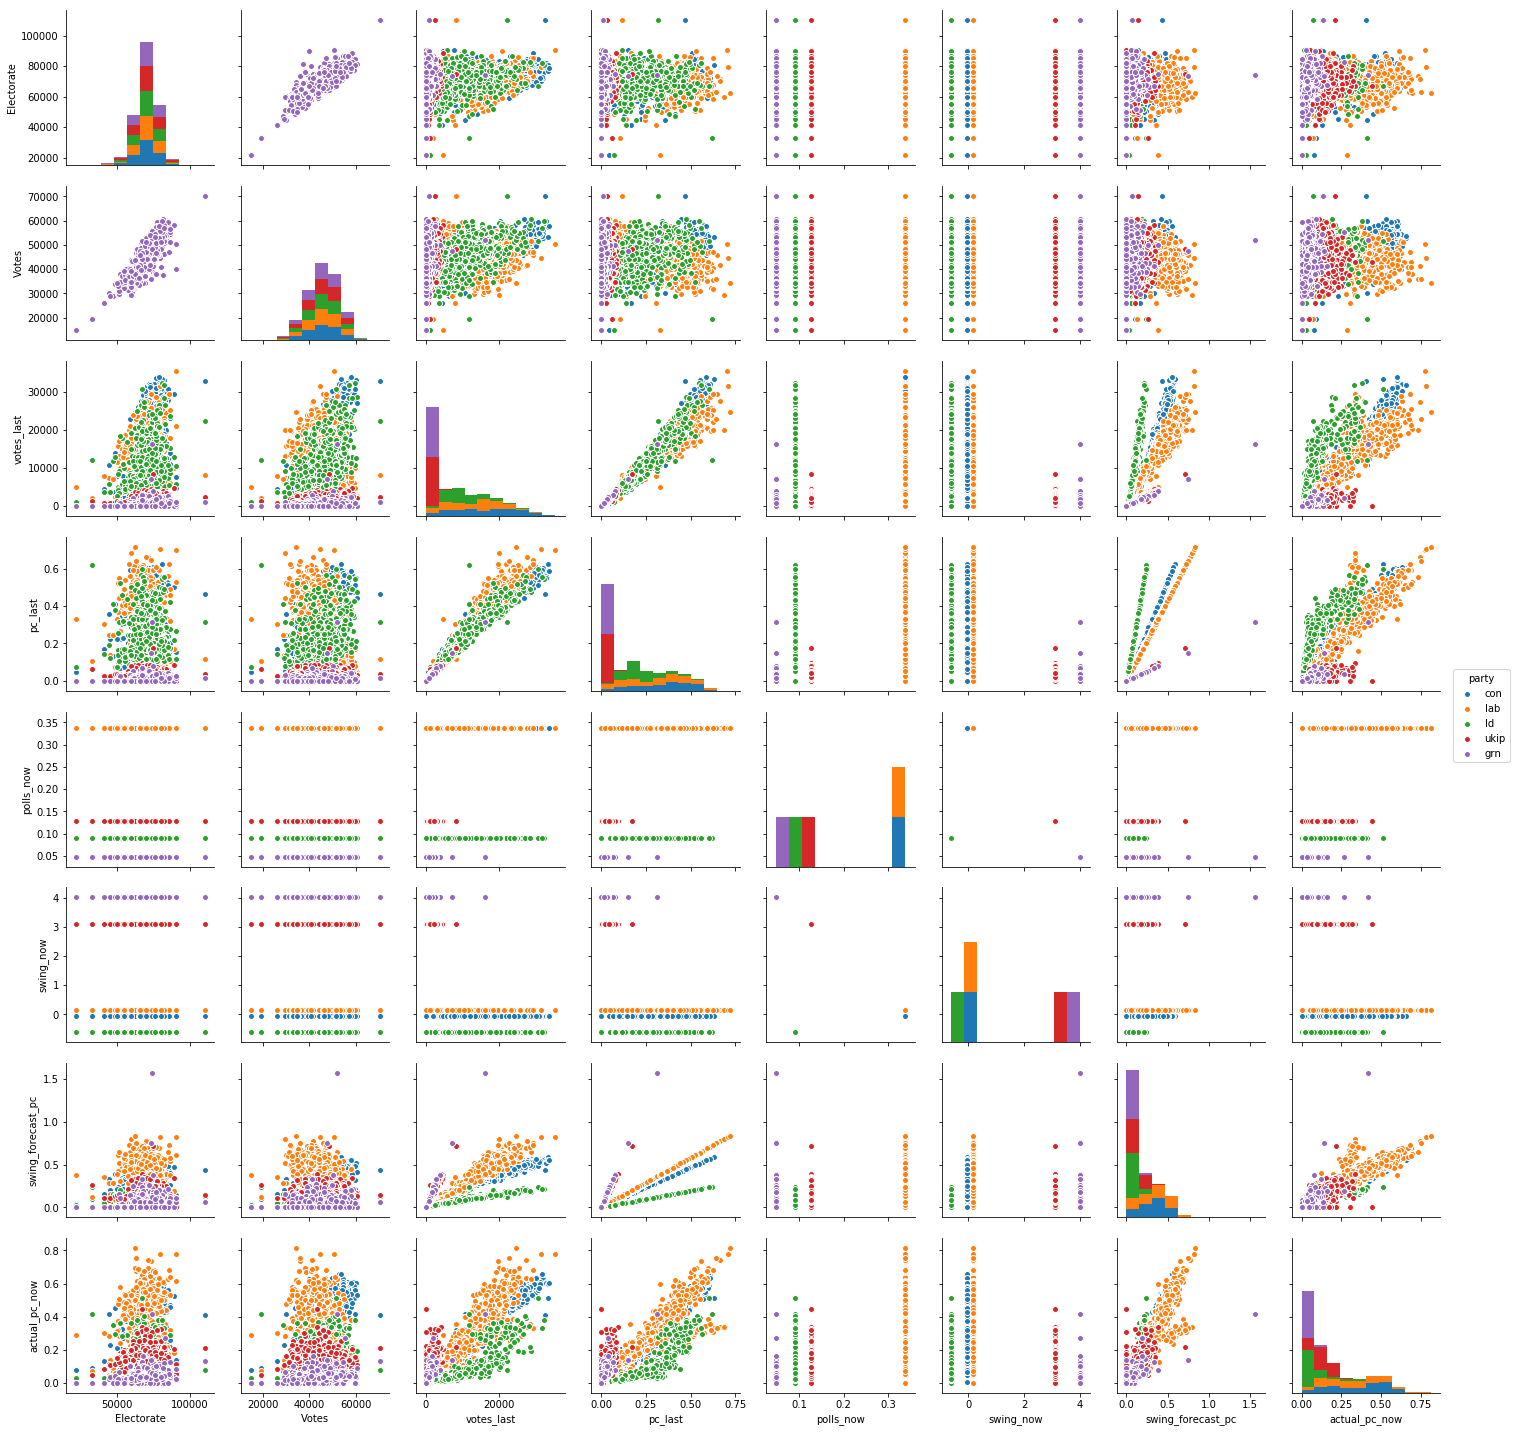

In [4]:
# Visualise feature relationships
sns.pairplot(df[['Electorate', 'Votes', 'votes_last', 'pc_last', 'polls_now', 'swing_now', 'swing_forecast_pc', 'actual_pc_now', 'party']],
             hue='party')

In [5]:
# Some useful functions
def score_model(model, X, y, repeats=5):
    """Calculates a "5x5" (repeated 5-fold) cross-validated shuffled mean average error.
       Returns the mean across 5 (default) repeats."""
    mmae = []
    for i in range(repeats):
        mmae += [-np.mean(model_selection.cross_val_score(model, X=X, y=y, cv=model_selection.KFold(n_splits=5, shuffle=True), scoring='neg_mean_absolute_error'))]
    return np.mean(mmae)

def score_features(model, features):
    """Helper function to run scoring function for a feature subset and using percent voteshare.
       This equates to average error per party per seat."""
    return score_model(model=model, X=df[features], y=df['actual_pc_now'])

### UNS model
Uniform National Swing has been pre-calculated here for you ("`swing_now`" and "`swing_forecast_pc`"). Let's evaluate how many seats are won by each party in 2015 according to this approach.

In [6]:
df.head()

,Press Association Reference,Constituency Name,Region,Electorate,Votes,party,votes_last,pc_last,win_last,polls_now,swing_now,swing_forecast_pc,swing_forecast_win,actual_win_now,actual_pc_now,con,grn,lab,ld,ukip,Region_East Midlands,Region_Eastern,Region_London,Region_North East,Region_North West,Region_Northern Ireland,Region_Scotland,Region_South East,Region_South West,Region_Wales,Region_West Midlands,Region_Yorkshire and the Humber,won_here_last
0,1.0,Aberavon,Wales,50838.0,30958,con,4411.0,0.142483,lab,0.338182,-0.062021,0.133646,lab,lab,0.118707,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1.0,Aberavon,Wales,50838.0,30958,lab,16073.0,0.519187,lab,0.337273,0.163400,0.604022,lab,lab,0.489040,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,1.0,Aberavon,Wales,50838.0,30958,ld,5034.0,0.162607,lab,0.090000,-0.609159,0.063554,lab,lab,0.044317,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1.0,Aberavon,Wales,50838.0,30958,ukip,489.0,0.015796,lab,0.127273,3.109344,0.064910,lab,lab,0.157694,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1.0,Aberavon,Wales,50838.0,30958,grn,0.0,0.000000,lab,0.048182,4.008203,0.000000,lab,lab,0.022555,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [7]:
# Seats won in 2010
(df[['Constituency Name', 'win_last']]
    .drop_duplicates()
    .groupby('win_last')
    .count()
    .sort_values('Constituency Name', ascending=False)
)

,Constituency Name
win_last,
con,306
lab,258
ld,57
DUP,8
SNP,6
SF,5
PC,3
SDLP,3
APNI,1


In [8]:
# Seats forecast to win in 2015 using UNS model
(df[['Constituency Name', 'swing_forecast_win']]
    .drop_duplicates()
    .groupby('swing_forecast_win')
    .count()
    .sort_values('Constituency Name', ascending=False)
)

,Constituency Name
swing_forecast_win,
lab,325
con,294
other,25
grn,3
ukip,2
ld,1


In [9]:
# Seats actually won in 2015 (from election results)
(df[['Constituency Name', 'actual_win_now']]
    .drop_duplicates()
    .groupby('actual_win_now')
    .count()
    .sort_values('Constituency Name', ascending=False)
)

,Constituency Name
actual_win_now,
con,330
lab,232
snp,56
DUP,8
ld,8
SF,4
SDLP,3
pc,3
UUP,2


In [10]:
# Total seat forecast accuracy = 79% of constituencies correctly predicted
(df[['Constituency Name', 'swing_forecast_win', 'actual_win_now']]
     .drop_duplicates()
     .apply(lambda row: row['swing_forecast_win'] == row['actual_win_now'], axis=1)
     .mean()
)

0.7861538461538462

In [11]:
# Total average error per party per seat = 4.45%
(df[['Constituency Name', 'actual_pc_now', 'swing_forecast_pc']]
    .apply(lambda row: abs(row['actual_pc_now'] - row['swing_forecast_pc']), axis=1)
    .mean()
)

0.0444840667581312

### Simple ML model

In [12]:
model = linear_model.LinearRegression()

In [13]:
# Available features
df.columns

Index(['Press Association Reference', 'Constituency Name', 'Region',
       'Electorate', 'Votes', 'party', 'votes_last', 'pc_last', 'win_last',
       'polls_now', 'swing_now', 'swing_forecast_pc', 'swing_forecast_win',
       'actual_win_now', 'actual_pc_now', 'con', 'grn', 'lab', 'ld', 'ukip',
       'Region_East Midlands', 'Region_Eastern', 'Region_London',
       'Region_North East', 'Region_North West', 'Region_Northern Ireland',
       'Region_Scotland', 'Region_South East', 'Region_South West',
       'Region_Wales', 'Region_West Midlands',
       'Region_Yorkshire and the Humber', 'won_here_last'],
      dtype='object')

In [14]:
# All features = 3.2% average error per party per seat
score_features(
    model=model,
    features=parties[1:] + \
        ['Region_' + x for x in df.Region.unique()[1:]] + \
        ['Electorate', 'Votes', 'votes_last', 'pc_last', 'won_here_last',
         'polls_now', 'swing_now', 'swing_forecast_pc']
)

/Users/john/.virtualenvs/sixfifty-hackathon/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


0.031714043793804506

# Over to you...!

In [15]:
# Model away...